# Fastjet Example
Use [fastjet](https://github.com/scikit-hep/fastjet) to cluster jets in python. This example uses the [LHC Olympics dataset](https://lhco2020.github.io/homepage/).

## Imports

In [42]:
import fastjet as fj
import energyflow as ef
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from cycler import cycler
import awkward as ak
import vector
import h5py

In [2]:
# Define plot style
mpl.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "#B6BFC3",
        "#3B515B",
        "#0271BB",
        "#E2001A",
    ]
)
mpl.rcParams["font.size"] = 15
mpl.rcParams["patch.linewidth"] = 1.25

## Load Data 

In [3]:
filepath = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.h5"

In [4]:
# Load everything into memory
df = pd.read_hdf(filepath)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(1100000, 2101)
Memory in GB: 17.227232456207275


In [5]:
# split data into signal and background
np_array = np.array(df)
background = np_array[np_array[:,2100]==0] 
signal = np_array[np_array[:,2100]==1]

In [6]:
# change the shape of the data to (n_events, n_particles, n_features) and remove the singal/background label
qcd_data = background[:, :2100].reshape(-1, 700, 3)
sig_data = signal[:, :2100].reshape(-1, 700, 3)

In [36]:
# save lengths of signal and background data for later use
len_bckg = len(qcd_data)
len_sig = len(sig_data)
print(f"Background events: {len_bckg}")
print(f"Signal events: {len_sig}")

Background events: 1000000
Signal events: 100000


In [7]:
data_full = np.concatenate((qcd_data, sig_data), axis=0)

In [48]:
print(qcd_data.shape)

(1000000, 700, 3)


In [49]:
print(qcd_data.shape[0])

1000000


save data in with features pt,eta,phi,signal

In [56]:
zeros = np.zeros([qcd_data.shape[0], qcd_data.shape[1], 1])
ones = np.ones([sig_data.shape[0], sig_data.shape[1], 1])
print(zeros.shape, ones.shape)
background_data = np.concatenate((qcd_data, zeros), axis=2)
signal_data = np.concatenate((sig_data, ones), axis=2)
print(background_data.shape, signal_data.shape)
data_full = np.concatenate((background_data, signal_data), axis=0)
print(data_full.shape)

(1000000, 700, 1) (100000, 700, 1)


(1000000, 700, 4) (100000, 700, 4)
(1100000, 700, 4)


In [15]:
print(sig_data.shape)
print(qcd_data.shape)

(100000, 700, 3)
(1000000, 700, 3)


Let's look at the data. We have 1.000.000 background events and 100.000 signal events. Each event consists of up to 700 Particles with pt, eta, phi.

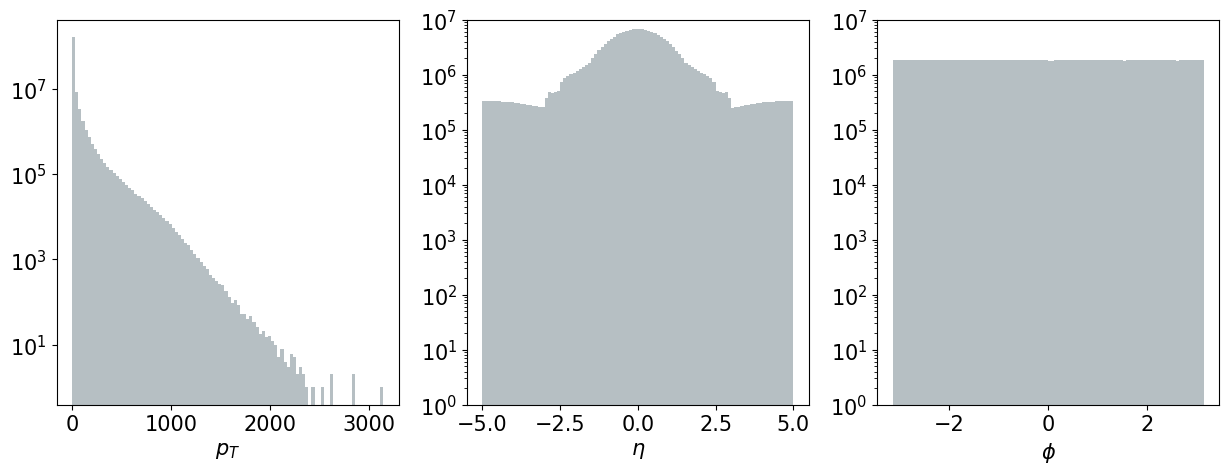

In [17]:
label_map = {"0": "$p_T$", "1": "$\eta$", "2": "$\phi$"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        qcd_data[:, :, index].flatten()[qcd_data[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 1:
        ax.set_ylim(1,)
    if index ==2 or index == 1:
        ax.set_ylim(1,1e7)
plt.show()

Define the jet clustering algorithm. We use the anti-kt algorithm with a radius parameter of 1.0.

In [8]:
jetdef = fj.JetDefinition(fj.antikt_algorithm, 1.0)

Awkward arrays are like numpy arrays, but they can have jagged dimensions. This is useful for particle physics, where we have a variable number of particles in each event. To benefit from the speed of awkward, we need to transform our data into an awkward array. For this, we first remove the zero padding and then tell the awkward array that our input data is a 4vector with eta, phi, pt, and mass.

In [9]:
# to awkard array
zrs = np.zeros((data_full.shape[0], data_full.shape[1], 1))
data_with_mass = np.concatenate((data_full, zrs), axis=2)
awkward_data = ak.from_numpy(data_with_mass)

In [10]:
# tell awkward that the data is in eta, phi, pt, mass format
vector.register_awkward()
unmasked_data = ak.zip({"pt": awkward_data[:,:,0], "eta": awkward_data[:,:,1], "phi": awkward_data[:,:,2], "mass": awkward_data[:,:,3]}, with_name="Momentum4D")
print(unmasked_data.type)

1100000 * 700 * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


In [11]:
#remove the padded data points
data = ak.drop_none(ak.mask(unmasked_data, unmasked_data.pt != 0))
print(data.type)

1100000 * var * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


Now the data can be clustered

In [12]:
cluster = fj.ClusterSequence(data, jetdef)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [13]:
# get jets and constituents
jets_out = cluster.inclusive_jets()
consts_out = cluster.constituents()

In [14]:
# define a function to sort ak.Array by pt
def sort_by_pt(data: ak.Array, ascending: bool = False, return_indices: bool = False):
    """Sort ak.Array by pt

    Args:
        data (ak.Array): array that should be sorted by pt. It should have a pt attribute.
        ascending (bool, optional): If True, the first value in each sorted group will be smallest; if False, the order is from largest to smallest. Defaults to False.
        return_indices (bool, optional): If True, the indices of the sorted array are returned. Defaults to False.

    Returns:
        ak.Array: sorted array
        ak.Array (optional): indices of the sorted array
    """
    if isinstance(data, ak.Array):
        try:
            temppt = data.pt
        except AttributeError:
            raise AttributeError(
                "Needs either correct coordinates or embedded vector backend"
            ) from None
    tmpsort = ak.argsort(temppt, axis=-1, ascending=ascending)
    if return_indices:
        return data[tmpsort], tmpsort
    else:   
        return data[tmpsort]

In [15]:
# sort jets and constituents by pt
jets_sorted, idxs = sort_by_pt(jets_out, return_indices=True)
consts_sorted_jets = consts_out[idxs]
consts_sorted = sort_by_pt(consts_sorted_jets)

In [25]:
# only take the first 2 highest pt jets
jets_awk = jets_sorted[:,:2]
consts_awk = consts_sorted[:,:2]

In [28]:
# max number of constituents in an event
max_consts = int(ak.max(ak.num(consts_awk, axis=-1)))
print(max_consts)

279


In [29]:
# Pad the data with zeros to make them all the same length
zero_padding = ak.zip({"pt": 0.0, "eta": 0.0, "phi": 0.0, "mass": 0.0}, with_name="Momentum4D")
padded_consts = ak.fill_none(ak.pad_none(consts_awk, max_consts, clip=True, axis=-1), zero_padding, axis=-1 )
print(padded_consts.type)

1100000 * var * 279 * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


In [30]:
# go back to numpy arrays
pt, eta, phi, mass = ak.unzip(padded_consts)
pt_np = ak.to_numpy(pt)
eta_np = ak.to_numpy(eta)
phi_np = ak.to_numpy(phi)
consts = np.stack((pt_np, eta_np, phi_np),axis=-1)
print(consts.shape)

(1100000, 2, 279, 3)


In [31]:
mask = np.expand_dims((consts[...,0] > 0).astype(int), axis=-1)
print(mask.shape)

(1100000, 2, 279, 1)


In [32]:
jets_pt_np = ak.to_numpy(jets_awk.pt)
jets_eta_np = ak.to_numpy(jets_awk.eta)
jets_phi_np = ak.to_numpy(jets_awk.phi)
jets_m_np = ak.to_numpy(jets_awk.m)
jets = np.stack((jets_pt_np, jets_eta_np, jets_phi_np, jets_m_np), axis=-1)
print(jets.shape)

(1100000, 2, 4)


split into signal and background

In [39]:
jets_background = jets[:len_bckg]
jets_signal = jets[len_bckg:]
mask_background = mask[:len_bckg]
mask_signal = mask[len_bckg:]
consts_background = consts[:len_bckg]
consts_signal = consts[len_bckg:]

## Save data

In [40]:
final_path = "/beegfs/desy/user/ewencedr/data/lhco/final_data/"

In [43]:
background_path = final_path + "processed_data_background.h5"
signal_path = final_path + "processed_data_signal.h5"
with h5py.File(background_path, "w") as f:
    f.create_dataset("jet_data", data=jets_background)
    f.create_dataset("constituents", data=consts_background)  
    f.create_dataset("mask", data=mask_background)  
with h5py.File(signal_path, "w") as f:
    f.create_dataset("jet_data", data=jets_signal)
    f.create_dataset("constituents", data=consts_signal)  
    f.create_dataset("mask", data=mask_signal)  

# Compare to provided features

In [79]:
label_map = {"0": "pt", "1": "eta", "2": "phi", "3": "mass"}

## Constituent Features

In [48]:
x_background = consts_background[:,0]
y_background = consts_background[:,1]
x_signal = consts_signal[:,0]
y_signal = consts_signal[:,1]
print(x_background.shape)

(1000000, 279, 3)


### Background

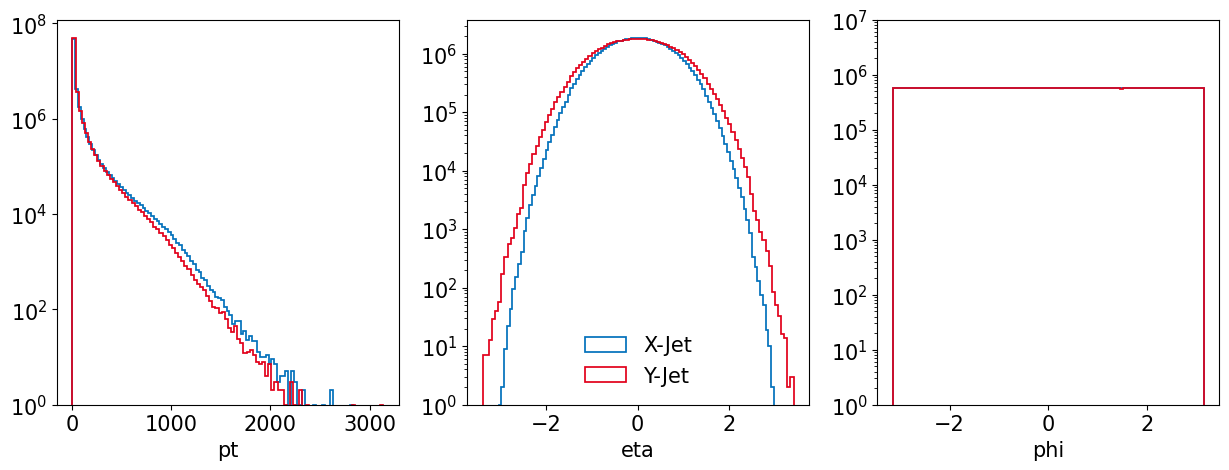

In [126]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # cycle through the colors
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        x_background[:, :, index].flatten()[x_background[:, :, index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        y_background[:, :, index].flatten()[y_background[:, :, index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e7)
    if index == 1:
        ax.legend(frameon=False)
plt.show()

### Signal

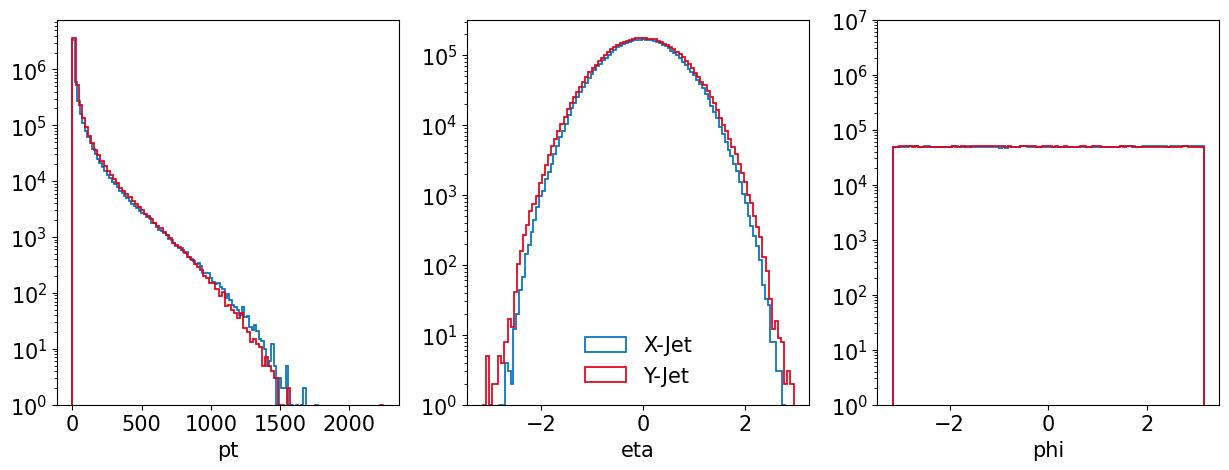

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # cycle through the colors
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        x_signal[:, :, index].flatten()[x_signal[:, :, index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        y_signal[:, :, index].flatten()[y_signal[:, :, index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e7)
    if index == 1:
        ax.legend(frameon=False)
plt.show()

## Jet Features

### Load and prepare provided features

In [57]:
path_features = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.features.h5"

In [56]:
df = pd.read_hdf(path_features)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))


(1100000, 15)
Memory in GB: 0.13113021850585938


In [66]:
feats = np.array(df)
background_feats = feats[feats[...,-1]==0][:,:-1]
signal_feats = feats[feats[...,-1]==1][:,:-1]
print(background_feats.shape)
print(signal_feats.shape)

(1000000, 14)
(100000, 14)


In [72]:
def to_ptyphim(feats):
    """  px, py, pz, mj --> pt, eta, phi, mj"""
    p3 = feats[:, :3]
    e = np.sqrt(feats[:, 0]**2 + feats[:, 1]**2 + feats[:, 2]**2 + feats[:, 3]**2)
    p4 = np.concatenate((e[:, None],p3), axis=1)
    ptyphim = ef.ptyphims_from_p4s(p4, phi_ref=0)
    return ptyphim

In [76]:
feats_x_background = to_ptyphim(background_feats[:,:4])
feats_y_background = to_ptyphim(background_feats[:,7:11])
feats_x_signal = to_ptyphim(signal_feats[:,:4]) 
feats_y_signal = to_ptyphim(signal_feats[:,7:11])

### Prepare fastjet data

In [77]:
jets_x_background = jets_background[:,0]
jets_y_background = jets_background[:,1]
jets_x_signal = jets_signal[:,0]
jets_y_signal = jets_signal[:,1]

### Background

#### X-Jet

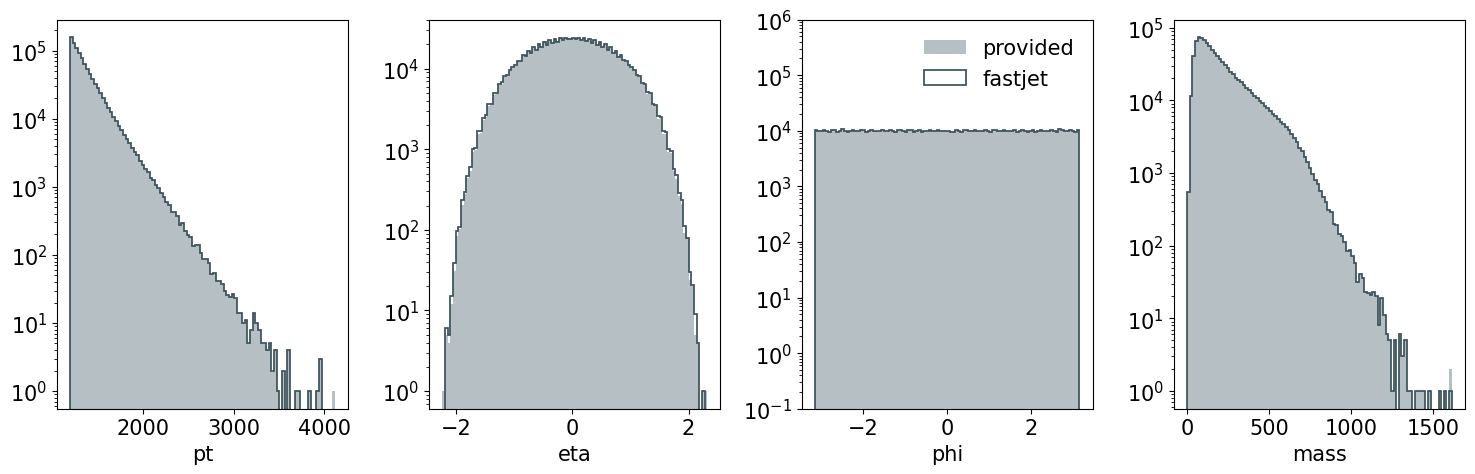

In [121]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_x_background[:, index], bins=100, label="provided"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_x_background[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

#### Y-Jet

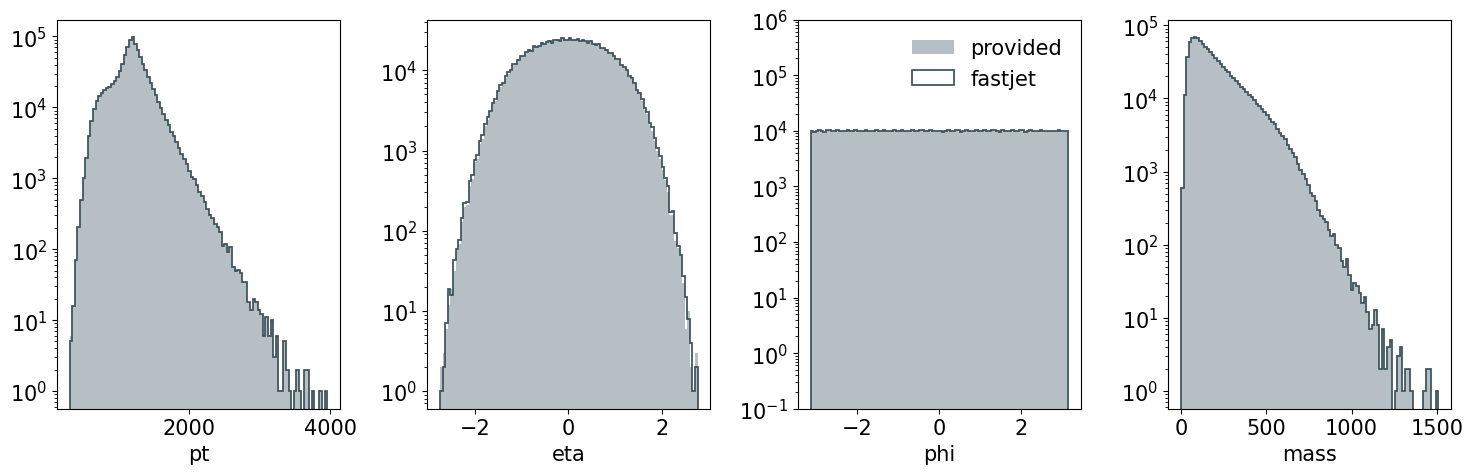

In [122]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_y_background[:, index], bins=100, label="provided"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_y_background[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1,1e6)
plt.tight_layout()
plt.show()

### Signal

#### X-Jet

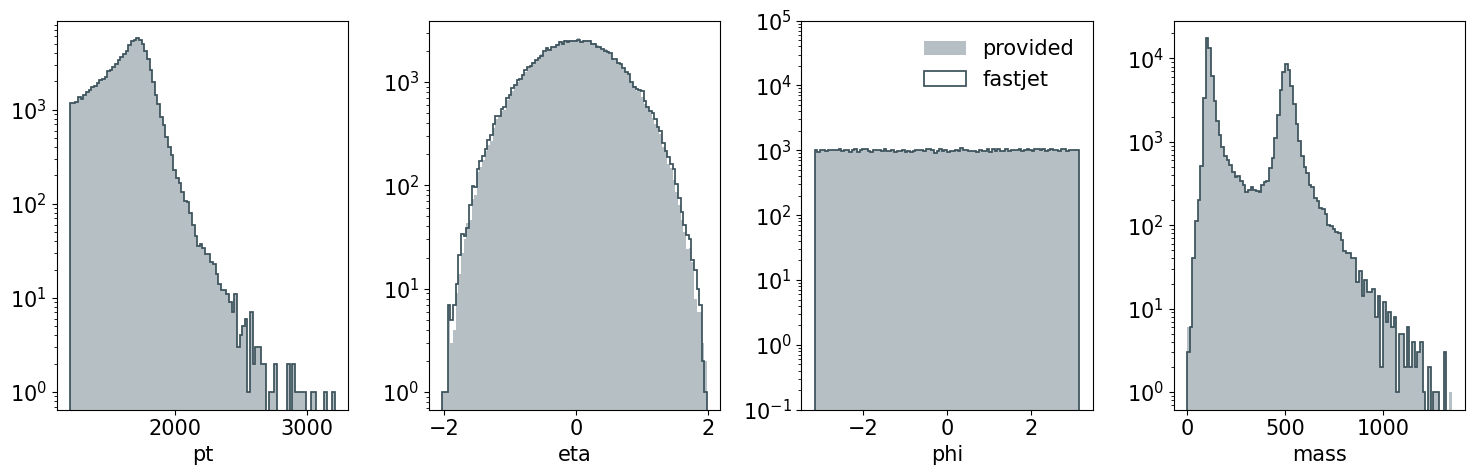

In [123]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_x_signal[:, index], bins=100, label="provided"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_x_signal[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e5)
plt.tight_layout()
plt.show()

#### Y-Jets

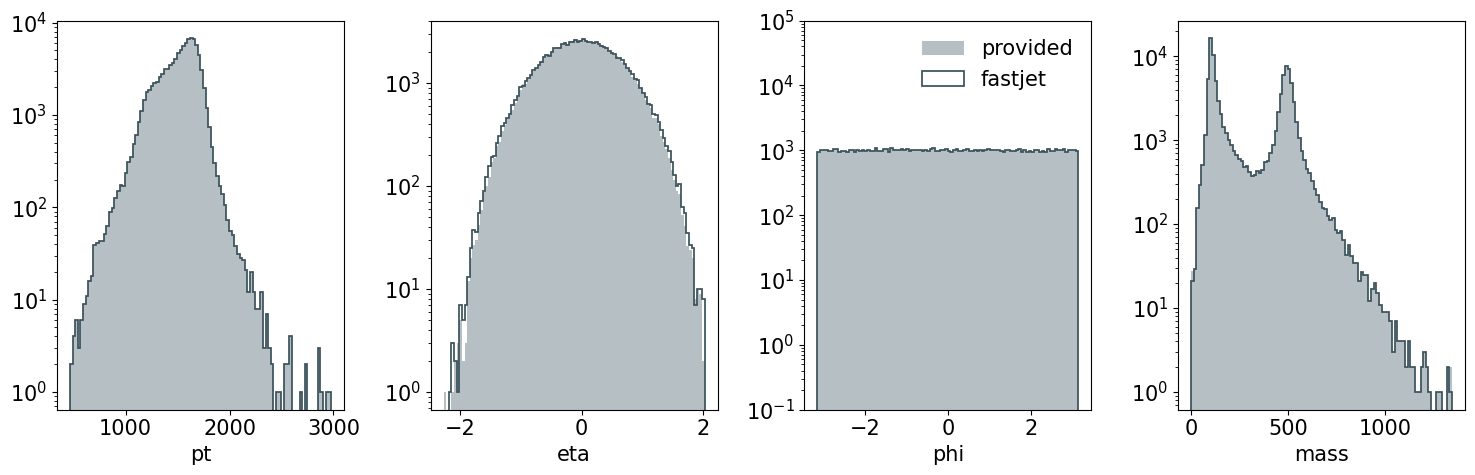

In [124]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_y_signal[:, index], bins=100, label="provided"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_y_signal[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e5)
plt.tight_layout()
plt.show()

In [67]:
print(jets.shape)

(1100000, 2, 4)


In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        np.array(background_feats[:, index]).flatten()[np.array(background_feats[:, index]).flatten() != 0], bins=100, label='original'
    )
    ax.hist(
        np.array(p4s_gen[:, index]).flatten()[np.array(p4s_gen[:, index]).flatten() != 0], bins=100, label='self clustered', histtype="step"
    )
    ax.legend()
    ax.set_xlabel(f"{df.columns[index]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
plt.show()

In [37]:
print(consts[0,0,:50])

[[ 8.38076172e+02  3.15002739e-01  2.74414682e+00]
 [ 2.96413147e+02  3.13269794e-01  2.74230170e+00]
 [ 1.22485298e+02  3.16103309e-01  2.74771357e+00]
 [ 1.20389732e+02  3.17118406e-01  2.75638413e+00]
 [ 8.75891800e+01  3.18489134e-01  2.76075792e+00]
 [ 4.66920853e+01  3.22169989e-01  2.76138330e+00]
 [ 3.43478508e+01  3.13941807e-01  2.75606537e+00]
 [ 2.87176704e+01  3.35890561e-01  2.74845529e+00]
 [ 8.19467545e+00  3.94431114e-01  2.71384931e+00]
 [ 3.41843152e+00  3.24367881e-01  2.72755480e+00]
 [ 1.43928969e+00  2.63392866e-01  2.51362038e+00]
 [ 1.32824254e+00  1.98608130e-01  2.94601679e+00]
 [ 5.76006949e-01  4.87898707e-01 -2.63647270e+00]
 [ 2.71377951e-01  9.45734739e-01  2.11785007e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+

In [331]:
tst = ak.to_numpy(padded_data)
print(tst.shape)

(100000, 2, 230)


In [321]:
print(consts_numpy.shape)
print(consts_numpy[0][0][0])
print(type(consts_numpy[0][0][0]))
print(len(consts_numpy[0][0]))

(100000, 2, 230)
(838.07617188, 0.31500274, 2.74414682, 0.)
<class 'numpy.void'>
230


In [ ]:
# remove zero-padded particles
# creation of the awkward array takes some time
trimmed_array = []
for evt in tqdm(qcd_data):
    trimmed = evt[~np.all(evt == 0, axis=-1)]
    trimmed_array.append(trimmed)
data_temp = ak.Array(trimmed_array)
# tell awkward what type of data we are using
vector.register_awkward()
data = ak.zip({"pt": data_temp[:,:,0], "eta": data_temp[:,:,1], "phi": data_temp[:,:,2], "mass": 0.0}, with_name="Momentum4D")
print(data.type)

In [168]:
print(consts.type)

100000 * var * var * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


In [166]:
print(len(jets_sorted[0]))
print(len(jets[0]))
print(jets_sorted[0].pt)
print(jets[0].pt)

9
2
[1.59e+03, 1.56e+03, 90.1, 20.9, 1.07, 0.971, 0.441, 0.438, 0.313]
[1.59e+03, 1.56e+03]


In [125]:
print(idxs)

[[8, 7, 6, 5, 4, 3, 2, 1, 0], [...], ..., [10, 9, 8, 7, 6, 5, 4, 2, 3, 1, 0]]


In [71]:
const_indx = cluster.constituent_index()

In [85]:
print(len(const_indx))
print(len(const_indx[1]))
print(len(const_indx[1][-1]))

100000
13
71


In [74]:
print(len(jets[0]))
print(jets[1][-1])

9
{px: -1.47e+03, py: 612, pz: 511, E: 1.67e+03}


In [26]:
test_array = np.array([1,2,3,4,5,6,7,8,9,10])
print(test_array[::-1])

[10  9  8  7  6  5  4  3  2  1]


In [153]:
# read out the constituents
consts = cluster.constituents()
consts_sorted_jets = consts[idxs]
consts_sorted = sort_by_pt(consts)
#consts_sorted = ak.sort(consts, axis=-1)
#consts_incl = fj.sorted_by_pt(consts)
t = consts[:,-2:]
print
for i in range(70435,70436):
    #print(len(consts[i]),len(t[i]))
    #print("T:", len(t[i,0]), len(t[1]))
    print(len(t[0]))
    print(len(consts[0]))
    


2
9


In [148]:
print(consts[0][-1])
print(consts_sorted_jets[0][0])

[{pt: 1.33, eta: 0.199, phi: 2.95, mass: 0}, ..., {pt: 8.19, eta: 0.394, ...}]
[{pt: 1.33, eta: 0.199, phi: 2.95, mass: 0}, ..., {pt: 8.19, eta: 0.394, ...}]


In [110]:
print(consts_sorted[0][-1].pt)

[0.271, 0.576, 1.33, 1.44, 3.42, 8.19, ..., 46.7, 87.6, 120, 122, 296, 838]


In [154]:
print(consts[0][-1])
print(consts[0][-1].pt)
print(consts[0][-1].eta)
print()
print(consts_sorted[0][-1].pt)
print(consts_sorted[0][-1].eta)

[{pt: 1.33, eta: 0.199, phi: 2.95, mass: 0}, ..., {pt: 8.19, eta: 0.394, ...}]
[1.33, 3.42, 296, 838, 122, 46.7, ..., 34.3, 28.7, 1.44, 0.576, 0.271, 8.19]
[0.199, 0.324, 0.313, 0.315, 0.316, ..., 0.336, 0.263, 0.488, 0.946, 0.394]

[838, 296, 122, 120, 87.6, 46.7, ..., 8.19, 3.42, 1.44, 1.33, 0.576, 0.271]
[0.315, 0.313, 0.316, 0.317, 0.318, ..., 0.324, 0.263, 0.199, 0.488, 0.946]


In [93]:
print(len(consts[-4]))
print(len(consts[1][-1]))
print(consts[-3][0])
print(consts_sorted[-1][0])
print(consts[0])

17
71
[{pt: 0.23, eta: 4.47, phi: -2.82, mass: 0}]
[{pt: 0.296, eta: -2.89, phi: 0.868, mass: 0}]
[[{pt: 0.313, eta: -4.87, phi: -1.25, mass: 0}], ..., [{pt: 1.33, ...}, ...]]


In [32]:
print(len(t[0][0]))
print(t[0][0][0])

47
{pt: 1.85, eta: -0.44, phi: -2.37, mass: 0}


In [14]:
print(max(ak.num(jets, axis=-2)))


NameError: name 'jets' is not defined

In [34]:
len(t)

100000

In [35]:
print(len(t[0][0]))
print(t[0][0][0])

47
{pt: 1.85, eta: -0.44, phi: -2.37, mass: 0}


In [15]:
print(t.type)
print(len(consts[0]))
print(consts[0])

100000 * var * var * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]
9
[[{pt: 0.313, eta: -4.87, phi: -1.25, mass: 0}], ..., [{pt: 1.33, ...}, ...]]


In [152]:
# Pad the data with zeros to make it all the same length
padded_data = ak.fill_none(ak.pad_none(t, 300, clip=False), ak.zip({"pt":0.0, "eta":0.0, "phi":0.0, "mass":0.0}, with_name="Momentum4D"), axis=-2)
#padded_data = ak.fill_none(ak.pad_none(consts, 300, clip=False), {"pt":0.0, "eta":0.0, "phi":0.0, "mass":0.0}, axis=-2)
print(padded_data.type)

100000 * var * union[var * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64], Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]]


In [131]:
print(sum(ak.is_none(padded_data)))
#print(sum(ak.is_none(padded_data[1])))
print(padded_data[1])

0
[[{pt: 0.375, eta: 2.54, phi: -1.27, mass: 0}], ..., {pt: 0, eta: 0, ...}]


In [120]:
consts_numpy = ak.to_numpy(padded_data)

TypeError: Conversion of irreducible unions to backend arrays is not supported.

This error occurred while calling

    ak.to_numpy(
        <Array [[[{pt: 0.313, ...}], ...], ...] type='100000 * var * union[...'>
    )

In [71]:
print(padded_data[70437])

[[{pt: 0.269, eta: -4.28, phi: -0.752, mass: 0}], [{pt: 0.543, ...}], ..., None]


In [74]:
print(sum(ak.num(padded_data)==300))

100000


In [73]:
print(ak.argmax(ak.num(padded_data)))

0


In [46]:
print(len(padded_data[3]))

300


In [41]:
data_numpy = ak.to_numpy(padded_data)

ValueError: cannot convert to RegularArray because subarray lengths are not regular (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-21/awkward-cpp/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

This error occurred while calling

    ak.to_numpy(
        <MomentumArray4D [[{pt: 1.84, ...}, ..., {...}], ...] type='100000 ...'>
    )

In [ ]:
# remove zero-padded particles
# creation of the awkward array takes some time
trimmed_array = []
for evt in tqdm(qcd_data):
    trimmed = evt[~np.all(evt == 0, axis=-1)]
    trimmed_array.append(trimmed)
data_temp = ak.Array(trimmed_array)

In [9]:
print(qcd_data.shape)
xyze_data = ef.p4s_from_ptyphims(qcd_data)
print(xyze_data.shape)

(1000, 700, 3)
(1000, 700, 4)


In [18]:
data = ak.from_numpy(qcd_data)
print(data)
data = []
for xyze in xyze_data:
    data2_temp = []
    for i in range(len(xyze)):
        data_temp = ak.zip({"px": xyze[i,0], "py": xyze[i,1], "pz": xyze[i,2], "E": xyze[i,3]})
        if xyze[i,0] != 0:
            data2_temp.append(data_temp)
    data.append(data2_temp)
print(data)

[[[1.84, -2.36, 0.368], [1.32, -2.46, 0.798], ..., [0, ..., 0], [0, 0, 0]], ...]


KeyboardInterrupt: 

This error occurred while calling

    ak.zip(
        {'px': 0.0, 'py': 0.0, 'pz': 0.0, 'E': 0.0}
    )

In [120]:
print(qcd_data.shape)
qcd2 = qcd_data.copy()
qcd2 = np.dtype([('pt', 'f4'), ('eta', 'f4'), ('phi', 'f4'), ('mass', 'f4')])
print(qcd_data[1])

(100000, 700, 3)


In [117]:
print(qcd_data.shape)
zrs = np.zeros((qcd_data.shape[0],qcd_data.shape[1],1))
print(zrs.shape)
qcd_data_with_mass = np.concatenate((qcd_data,zrs),axis=-1)
#zrs = qcd_data[~np.all(qcd_data == 0, axis=-1)]
#print(zrs.shape)
#t = np.trim_zeros(qcd_data[0,0])
trimmed_array = []
for evt in tqdm(qcd_data):
    trimmed = evt[~np.all(evt == 0, axis=-1)]
    trimmed_array.append(trimmed)
    #print(trimmed.shape)
    #awk_temp = ak.zip({"pt": trimmed[:,0], "eta": trimmed[:,1], "phi": trimmed[:,2], "mass": 0})
    #trimmed_array.append(awk_temp)
#print(trimmed_array[125])
vector.register_awkward()
data_final = ak.Array(trimmed_array)
#data = ak.zip({"pt": trimmed_array[:,:,0], "eta": trimmed_array[:,:,1], "phi": trimmed_array[:,:,2], "mass": trimmed_array[:,:,3]})
#print(data_final)
#print(data_final.type)
#print(ak.fields(data_final))

(100000, 700, 3)
(100000, 700, 1)


100%|██████████| 100000/100000 [00:02<00:00, 36625.77it/s]


In [148]:
print(ak.fields(data_final))
print(data_final[:,:,0])
vector.register_awkward()
data_final2 = ak.zip({"pt": data_final[:,:,0], "eta": data_final[:,:,1], "phi": data_final[:,:,2], "mass": 0},with_name="Momentum4D")
print(data_final2.type)
print(data_final2.fields)
print(data_final2[1][0].pt)
print(np.count_nonzero(qcd_data[1,:,0]))
print(qcd_data[1,0,:])

[]
[[1.84, 1.32, 7.52, 6.52, 2.11, 0.659, ..., 7.17, 5.71, 17.7, 11.8, 15.2], ...]
100000 * var * Momentum4D[pt: float64, eta: float64, phi: float64, mass: int64]
['pt', 'eta', 'phi', 'mass']
0.953230619430542
142
[ 0.95323062 -2.31241965 -0.23961659]


In [115]:
print(qcd_data.shape)
zrs = np.zeros((qcd_data.shape[0],qcd_data.shape[1],1))
print(zrs.shape)
qcd_data_with_mass = np.concatenate((qcd_data,zrs),axis=-1)
#zrs = qcd_data[~np.all(qcd_data == 0, axis=-1)]
#print(zrs.shape)
#t = np.trim_zeros(qcd_data[0,0])
trimmed_array = []
for evt in tqdm(qcd_data):
    trimmed = evt[~np.all(evt == 0, axis=-1)]
    #print(trimmed.shape)
    awk_temp = ak.zip({"pt": trimmed[:,0], "eta": trimmed[:,1], "phi": trimmed[:,2], "mass": 0})
    trimmed_array.append(awk_temp)
#print(trimmed_array[125])
vector.register_awkward()
data_final = ak.Array(trimmed_array, with_name="Momentum4D")
#data = ak.zip({"pt": trimmed_array[:,:,0], "eta": trimmed_array[:,:,1], "phi": trimmed_array[:,:,2], "mass": trimmed_array[:,:,3]})
print(data_final)
print(data_final.type)
print(ak.fields(data_final))


(100000, 700, 3)
(100000, 700, 1)


100%|██████████| 100000/100000 [00:47<00:00, 2116.65it/s]


KeyboardInterrupt: 

This error occurred while calling

    ak.to_layout(
        list-instance
        allow_record = False
        regulararray = False
    )

In [113]:
for i in data_final[:10]:
    print(i)

[{pt: 1.84, eta: 1.32, phi: 7.52, mass: 0}, ..., {pt: 0.368, eta: 0.798, ...}]
[{pt: 0.953, eta: 0.243, phi: 0.427, mass: 0}, ..., {pt: -0.24, eta: ..., ...}]
[{pt: 0.822, eta: 11.5, phi: 20.7, mass: 0}, ..., {pt: -0.0988, eta: 2.45, ...}]
[{pt: 0.49, eta: 0.416, phi: 1.49, mass: 0}, ..., {pt: 2.12, eta: -2.94, ...}]
[{pt: 1.09, eta: 3.38, phi: 1.36, mass: 0}, ..., {pt: -0.0137, eta: ..., ...}]
[{pt: 0.283, eta: 0.641, phi: 0.598, mass: 0}, ..., {pt: 2.24, eta: 1.04, ...}]
[{pt: 2.44, eta: 1.92, phi: 0.483, mass: 0}, ..., {pt: -0.612, eta: ..., ...}]
[{pt: 0.278, eta: 1.08, phi: 3.62, mass: 0}, ..., {pt: 0.0666, eta: ..., ...}]
[{pt: 0.216, eta: 0.897, phi: 0.384, mass: 0}, ..., {pt: 2.88, eta: 2.61, ...}]
[{pt: 0.196, eta: 0.511, phi: 0.759, mass: 0}, ..., {pt: -1.36, eta: ..., ...}]


In [ ]:

data = ak.zip({"pt": qcd_data2[:,:,0], "eta": qcd_data2[:,:,1], "phi": qcd_data2[:,:,2], "mass": qcd_data2[:,:,3]},with_name="Momentum4D")
print(data)

In [34]:
import vector
vector.register_awkward()

data = ak.Array(
    [[
        {"px": 1.2, "py": 3.2, "pz": 5.4, "E": 23.5},
        {"px": 32.2, "py": 64.21, "pz": 543.34, "E": 755.12},
        {"px": 32.45, "py": 63.21, "pz": 543.14, "E": 835.56},
    ],[
        {"px": 1.2, "py": 3.2, "pz": 5.4, "E": 23.5},
        {"px": 32.2, "py": 64.21, "pz": 543.34, "E": 755.12},
        {"px": 32.45, "py": 63.21, "pz": 543.14, "E": 835.56},
    ]],
)
print(data.type)
print(ak.fields(data))

2 * var * {px: float64, py: float64, pz: float64, E: float64}
['px', 'py', 'pz', 'E']


In [10]:

zrs = np.zeros((qcd_data.shape[0],qcd_data.shape[1],1))
print(zrs.shape)
qcd_data2 = np.concatenate((qcd_data,zrs),axis=-1)
print(qcd_data2.shape)
vector.register_awkward()
data = ak.zip({"pt": qcd_data2[:,:,0], "eta": qcd_data2[:,:,1], "phi": qcd_data2[:,:,2], "mass": qcd_data2[:,:,3]},with_name="Momentum4D")
print(data)

(1000, 700, 1)
(1000, 700, 4)
[[{pt: 1.84, eta: -2.36, phi: 0.368, mass: 0}, {...}, ..., {pt: 0, ...}], ...]


In [149]:
cluster = fj.ClusterSequence(data_final2, jetdef)

In [164]:
print(len(cluster.inclusive_jets()))
print(len(cluster.constituents()[0]))
print(cluster.constituents()[0])

100000
9
[[{pt: 0.313, eta: -4.87, phi: -1.25, mass: 0}], ..., [{pt: 1.33, ...}, ...]]


In [181]:
for jet in cluster.inclusive_jets()[0]:
    print(jet)
print("---")
for jet in cluster.inclusive_jets()[1][::-1]:
    print(jet.pt, jet.mass)

{px: 0.0977, py: -0.298, pz: -20.5, E: 20.5}
{px: -0.434, py: 0.0609, pz: 1.21, E: 1.29}
{px: 0.39, py: -0.206, pz: 19.1, E: 19.1}
{px: -0.825, py: -0.512, pz: 6.98, E: 7.06}
{px: 0.695, py: 0.816, pz: -37, E: 37}
{px: 17.2, py: 11.9, pz: -23.4, E: 31.6}
{px: 81.1, py: 39.2, pz: -476, E: 484}
{px: 1.4e+03, py: -675, pz: -452, E: 1.64e+03}
{px: -1.47e+03, py: 612, pz: 511, E: 1.67e+03}
---
1260.0492381901236 389.53155379908804
622.4544504778902 22.99916552249741
571.1509239517713 57.76978708077366
18.12601970993874 5.032401064731704
5.748742979511506 0.5453846855739463
3.9995428126762143 1.4182442260625165
1.2714441069996443 0.425274700984893
1.0898504257202148 8.429369702178807e-08
0.9710561037063599 -4.76837158203125e-07
0.7946855425834655 0.0
0.7871347665786743 -8.259061849445711e-07
0.4272216260433197 1.4901161193847656e-08
0.3745048940181732 0.0


In [161]:
for i in range(0, 5):
    print(len(cluster.inclusive_jets()[i]))
    #print(len(cluster.constituents()[i][1]))

9
13
9
15
9


## Cluster Jets

We define a function that clusters the given constituents into jets. The [Anti-$k_t$ algorithm](https://arxiv.org/abs/0802.1189) with $R=1.0$ is used to do so. Only the first two leading $p_T$ jets are returned.

In [6]:
# define clustering function
def cluster(data: np.array, n_events: int = 1000) -> list:
    """cluster the data with fastjet

    Args:
        data (np.array): data to cluster
        n_events (int, optional): events that should be clustered. Defaults to 1000.

    Returns:
        list: clustered data
    """
    out = []

    # Loop over events
    for ievt in tqdm(range(n_events)):
        # Build a list of all particles
        pjs = []
        for i in range(data.shape[1]):
            pj = fj.PseudoJet()

            # skip zero padded particles
            if data[ievt, i, 0] == 0:
                continue

            pj.reset_PtYPhiM(data[ievt, i, 0], data[ievt, i, 1], data[ievt, i, 2], 0)
            pjs.append(pj)

        # run jet clustering with AntiKt, R=1.0
        R = 1.0
        jet_def = fj.JetDefinition(fj.antikt_algorithm, R)

        # Save the two leading jets
        jets = jet_def(pjs)
        jets = [j for j in jets if j.pt() > 30.0]
        out.append([jets[0], jets[1]])

    return out

In [32]:
print(akqcd_data))

[[[1.84, -2.36, 0.368], [1.32, -2.46, 0.798], [7.52, ... 0], [0, 0, 0], [0, 0, 0]]]


In [33]:
# actually cluster the data
# this is what takes some time
out_qcd = cluster(qcd_data, n_events=len(qcd_data))
out_sig = cluster(sig_data, n_events=len(sig_data))
out = [out_qcd, out_sig]

  0%|          | 0/100000 [00:00<?, ?it/s]


AttributeError: no field named 'shape'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.4/src/awkward/highlevel.py#L1124)

### Read out jet properties

Fastjet returns a list of `PseudoJet` objects. We convert these to a list of tuples containing the jet $p_T$, $\eta$, $\phi$, and $m$.

In [14]:
# separate the leading and subleading jets
for jets in out:
    x_jets = []
    y_jets = []
    for jets in jets:
        x_jet = jets[0]
        y_jet = jets[1]
        x_jets.append(x_jet)
        y_jets.append(y_jet)
    x_jets = np.array(x_jets)
    y_jets = np.array(y_jets)

In [28]:
for c, xy_jets in enumerate([x_jets, y_jets]):
    print(f"----{'x' if c == 0 else 'y'}----")
    # get padded constituents, relative coordinates and mask in the wanted format
    len_padding = 300
    constituents = []
    constituents_xyze = []
    rel_constituents = []
    mask = []
    jet_mass = []
    jet_pt = []
    jet_eta = []
    jet_phi = []
    jet_px = []
    jet_py = []
    jet_pz = []
    jet_e = []
    for jet in xy_jets:
        # get constituents
        const_pt = np.array(
            [(jet.constituents()[i].perp()) for i in range(len(jet.constituents()))]
        )
        const_eta = np.array(
            [
                (jet.constituents()[i].pseudorapidity())
                for i in range(len(jet.constituents()))
            ]
        )
        const_phi = np.array(
            [(jet.constituents()[i].phi_std()) for i in range(len(jet.constituents()))]
        )
        # xyze
        const_px = np.array(
            [(jet.constituents()[i].px()) for i in range(len(jet.constituents()))]
        )
        const_py = np.array(
            [(jet.constituents()[i].py()) for i in range(len(jet.constituents()))]
        )
        const_pz = np.array(
            [(jet.constituents()[i].pz()) for i in range(len(jet.constituents()))]
        )
        const_e = np.array(
            [(jet.constituents()[i].e()) for i in range(len(jet.constituents()))]
        )

        # concatenate
        consts = np.concatenate(
            (const_pt[:, None], const_eta[:, None], const_phi[:, None]), axis=1
        )
        consts_xyze = np.concatenate(
            (const_px[:, None], const_py[:, None], const_pz[:, None], const_e[:, None]),
            axis=1,
        )
        # sort constituents by pT from high to low
        consts = consts[np.argsort(consts[:, 0])[::-1]]

        # pad constituents and mask
        padded_consts = np.pad(
            consts, ((0, len_padding - len(consts)), (0, 0)), "constant", constant_values=0
        )
        padded_consts_xyze = np.pad(
            consts_xyze,
            ((0, len_padding - len(consts_xyze)), (0, 0)),
            "constant",
            constant_values=0,
        )
        padded_mask = np.pad(
            np.ones(len(consts)),
            (0, len_padding - len(consts)),
            "constant",
            constant_values=0,
        )

        # relative coordinates
        rel_constituents_temp = padded_consts.copy()
        rel_constituents_temp[:, 0] = rel_constituents_temp[:, 0] / jet.perp()
        rel_constituents_temp[:, 1] = rel_constituents_temp[:, 1] - jet.pseudorapidity()
        rel_constituents_temp[:, 2] = rel_constituents_temp[:, 2] - jet.phi_std()

        # fix phi range
        rel_constituents_temp[:, 2] = np.where(
            rel_constituents_temp[:, 2] > np.pi,
            rel_constituents_temp[:, 2] - 2 * np.pi,
            rel_constituents_temp[:, 2],
        )
        rel_constituents_temp[:, 2] = np.where(
            rel_constituents_temp[:, 2] < -np.pi,
            rel_constituents_temp[:, 2] + 2 * np.pi,
            rel_constituents_temp[:, 2],
        )

        # jet variables & append to list
        jet_mass.append(jet.m())
        jet_pt.append(jet.perp())
        jet_eta.append(jet.pseudorapidity())
        jet_phi.append(jet.phi_std())
        jet_px.append(jet.px())
        jet_py.append(jet.py())
        jet_pz.append(jet.pz())
        jet_e.append(jet.e())
        constituents.append(padded_consts)
        constituents_xyze.append(padded_consts_xyze)
        rel_constituents.append(rel_constituents_temp)
        mask.append(padded_mask)
    mask = np.array(mask)
    constituents = np.array(constituents) * mask[:, :, None]
    constituents_xyze = np.array(constituents_xyze)
    rel_constituents = np.array(rel_constituents) * mask[:, :, None]
    jet_mass = np.array(jet_mass)
    jet_pt = np.array(jet_pt)
    jet_eta = np.array(jet_eta)
    jet_phi = np.array(jet_phi)
    jet_px = np.array(jet_px)
    jet_py = np.array(jet_py)
    jet_pz = np.array(jet_pz)
    jet_e = np.array(jet_e)
    jet_data = np.concatenate(
        (
            jet_pt[:, None],
            jet_eta[:, None],
            jet_phi[:, None],
            jet_mass[:, None],
            jet_px[:, None],
            jet_py[:, None],
            jet_pz[:, None],
            jet_e[:, None],
        ),
        axis=1,
    )

----x----


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed